In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from models import Encoder, Decoder, propPred, ChemVAE
from utils import smile_to_ohe, labels_to_smiles
from dataset import Zinc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [11]:
def training_prog(log):
    
    res = []
    
    with open(log, 'r') as fi:
        for line in fi:
            if 'Train Loss' in line:
                    
                train_loss = line.split()[-5]
                train_acc = line.split()[-1][:-1]
                
                next_line = fi.readline()
                
                valid_loss = next_line.split()[-5]
                valid_acc = next_line.split()[-1][:-1]
                
                res.append([train_loss, train_acc, valid_loss, valid_acc])
                
    df = pd.DataFrame(res, columns=['train_loss', 'train_acc', 'valid_loss', 'valid_acc'])
    df = df.apply(pd.to_numeric, errors='ignore')
    
    return df

In [13]:
df = training_prog('./logs/leaky_100.log')

In [14]:
df.head()

,train_loss,train_acc,valid_loss,valid_acc
0,28346.650,30.27,21233.487,39.68
1,18424.694,49.26,14214.314,60.95
2,14354.081,60.37,14950.615,59.92
3,12165.496,66.35,9168.663,74.49
4,10508.500,70.77,36175.249,34.87


In [27]:
def plot_metrics(df):
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))

    x = range(len(df))

    ax[0].plot(x, df['train_loss'], label='Training')
    ax[0].plot(x, df['valid_loss'], label='Valid')
    ax[0].legend()
    ax[0].set_title('Loss')

    ax[1].plot(x, df['train_acc'])
    ax[1].plot(x, df['valid_acc'])
    ax[1].set_title('Accuracy')

    for a in ax.flat:
        a.grid(alpha=0.2)
        a.set_axisbelow(True)
        a.set_xlabel('Epoch')

    plt.tight_layout()

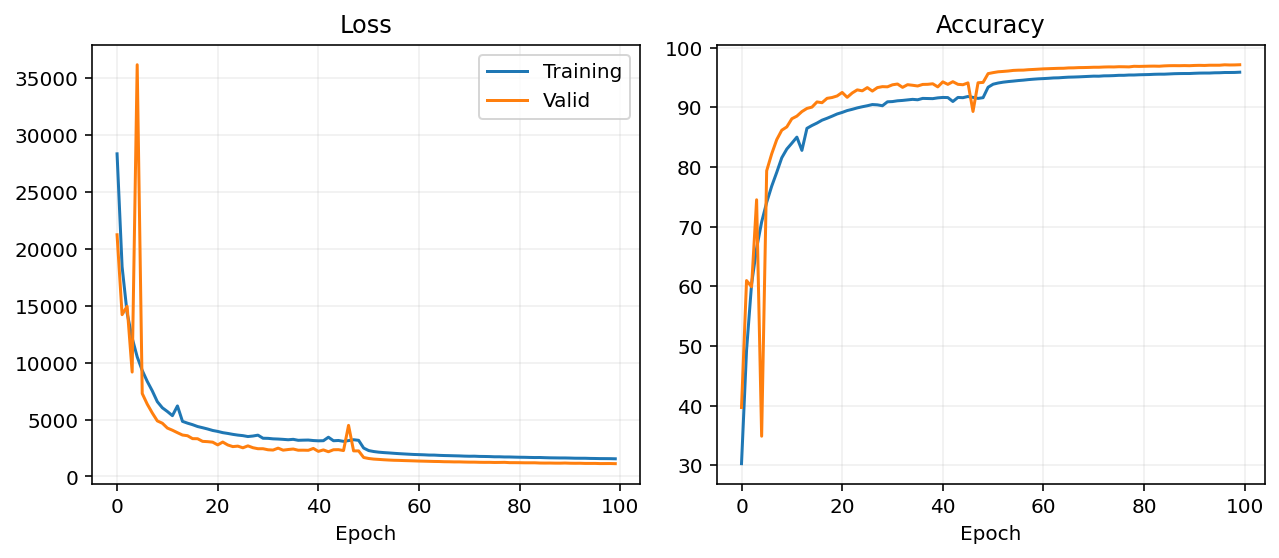

In [28]:
plot_metrics(df)

In [30]:
def get_smile_prog(log, smile):
    
    # save each smile separately
    res = []
    
    with open(log, 'r') as fi:
        for line in fi:
            if smile in line:
                res.append(fi.readline().split()[-1])
                
    return res

In [36]:
fixed_1 = get_smile_prog('./logs/leaky_100.log', 'COc1ccc(C(=O)N(C)[C@@H](C)C/C(N)=N/O)cc1O')
fixed_2 = get_smile_prog('./logs/leaky_100.log', 'Cc1ccc(C)c(-n2c(SCCCCCO)nc3ccccc3c2=O)c1')
fixed_3 = get_smile_prog('./logs/leaky_100.log', 'Fc1ccc(F)c(C[NH+]2CCC(n3cc(-c4cccnc4)nn3)CC2)c1F')
fixed_4 = get_smile_prog('./logs/leaky_100.log', 'N#Cc1ccc(OC2CCC(NC(=O)c3ccc[nH]3)CC2)nc1')
fixed_5 = get_smile_prog('./logs/leaky_100.log', 'S=C1[NH+]=N[C@@H]2c3c(sc4c3CC[NH+](Cc3ccccc3)C4)-n3c(n[nH]c3=S)N12')

In [33]:
fixed_1[:10]

['------------------------------------------------------------------------------------------------------------------------',
 'CCC1ccc(CC==))CCC[[C@H](CCCCCCCCCCCCC1',
 'CCc1cc(NC(=O)NCCC[C@@H](CCCCCCCCO))CC))c1',
 'COc1ccc(C(=O)2CCC[C@@H](C))))CCCC)))))c1',
 'COc1ccc(C(=O)N(C)[C@@H](C)N(((CC))C2)c11',
 'COcccc(NC(=O)N(C)CC(@O)(CCFFFFFFF)ccc11',
 'COc1ccc(C(=O)N(C)[C@@H](C)CCCCC)))=O)cc1C',
 'COc1ccc(C(=O)N(C)[C@@H](C)CCCCCC(C)C)cc1C',
 'COc1ccc(C(=O)N(C)[C@@H](C)CCC(C)(C)C)cc1O',
 'COc1ccc(C(=O)N(C)[C@@H](C)C(C(C(CCCC)cc1']

In [56]:
def check_smiles(template, smiles):
    
    arr = np.zeros((len(smiles), len(template)))
    
    # mark correct tokens
    for i, smile in enumerate(smiles):
        for j, char in enumerate(template):
            
            # will raise error if pred is shorter than template
            try:
                if smile[j] == char:
                    arr[i, j] = 1
            except:
                continue
                
    return arr

In [112]:
def plot_smiles(template, smiles, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    arr = check_smiles(template, smiles)
    
    p = ax.imshow(arr, aspect='auto', cmap='bwr_r')
    ax.set_ylabel('Epoch', size=13)
    ax.xaxis.tick_top()
    
    ax.set_xticks(np.arange(len(template)))
    ax.set_xticklabels(list(template), size=13)
    
    plt.colorbar(p, fraction=0.02)

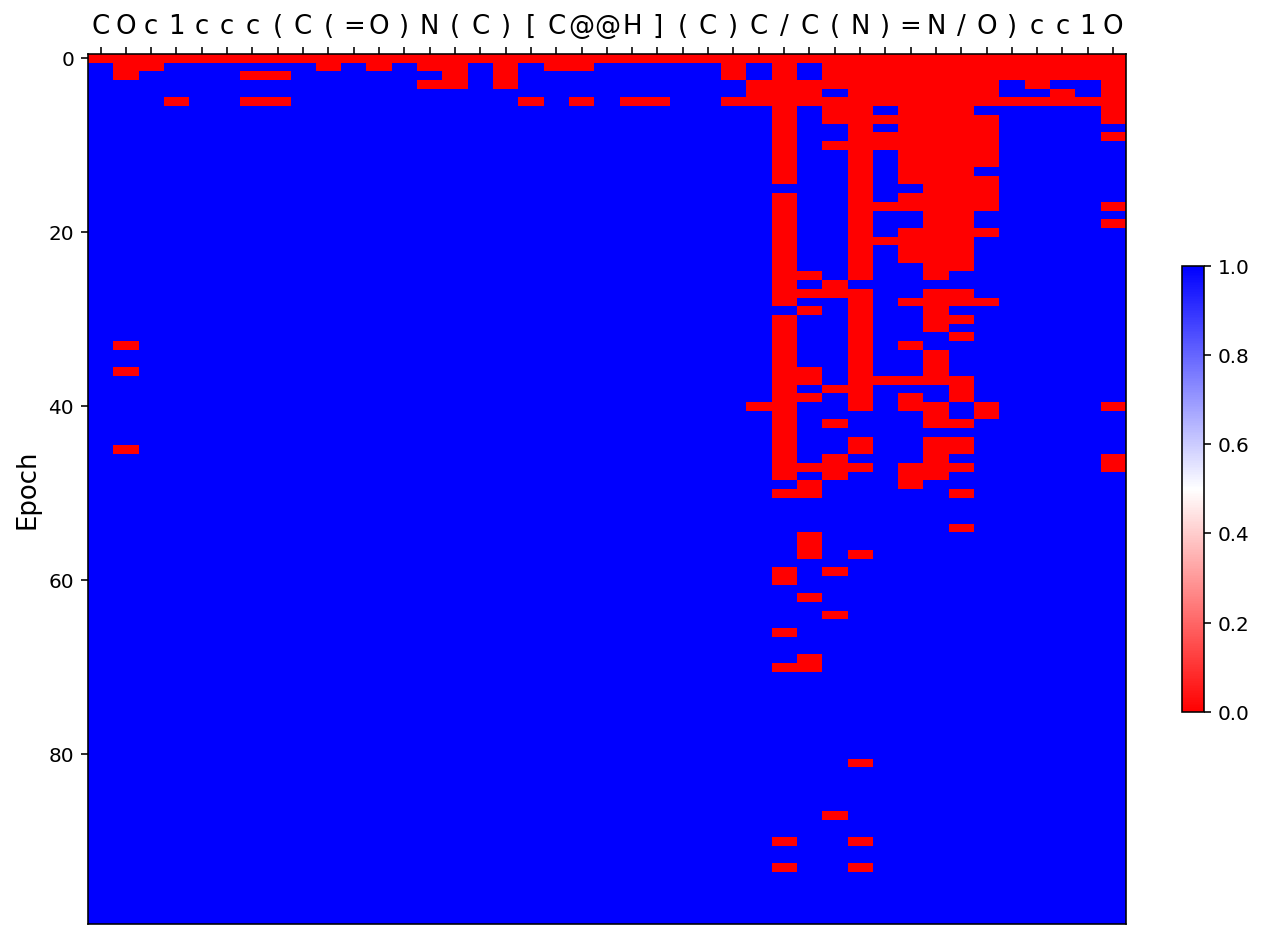

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_smiles('COc1ccc(C(=O)N(C)[C@@H](C)C/C(N)=N/O)cc1O', fixed_1)

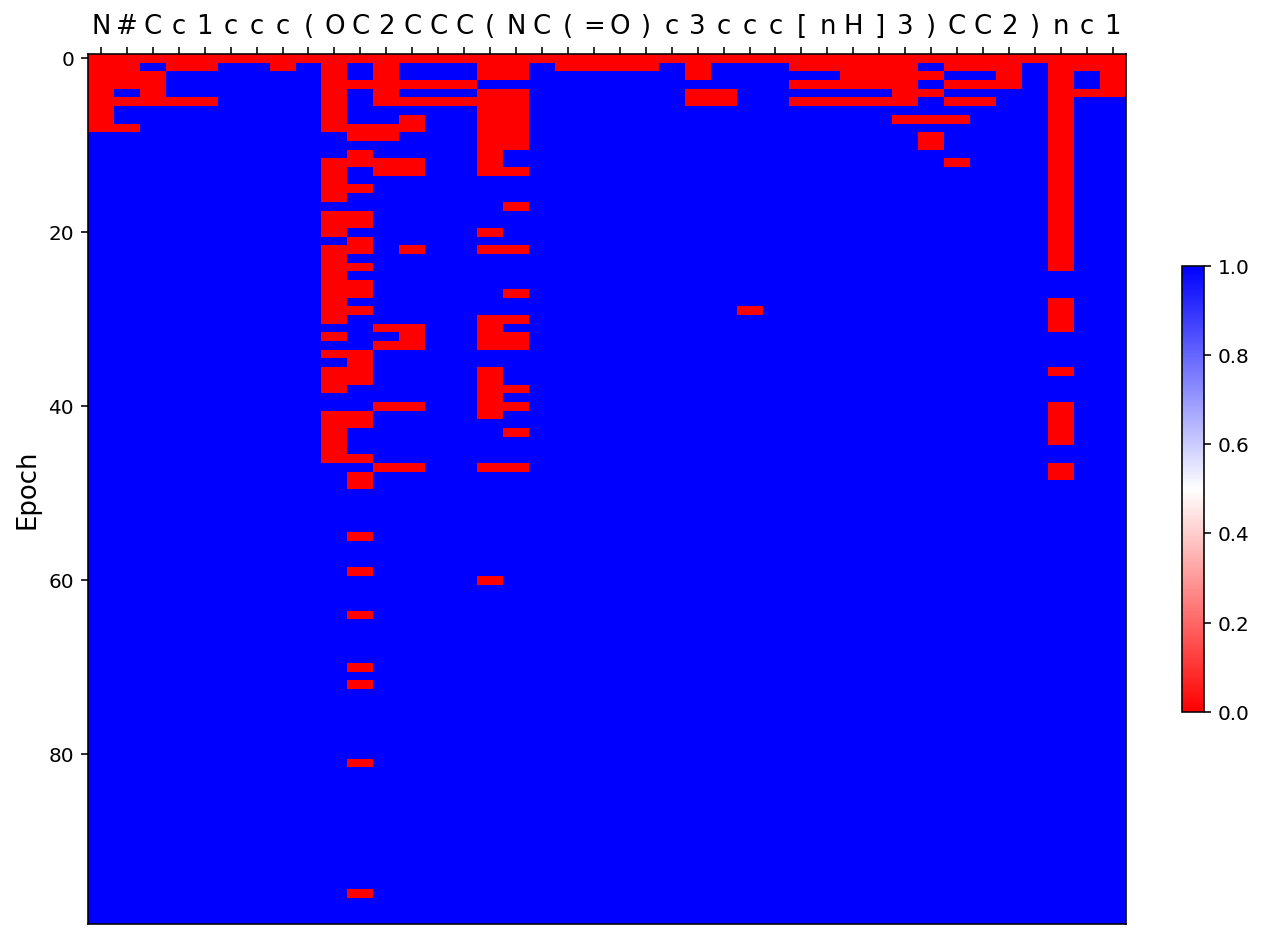

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_smiles('N#Cc1ccc(OC2CCC(NC(=O)c3ccc[nH]3)CC2)nc1', fixed_4)

In [6]:
def make_model(checkpoint):
    
    dataset = Zinc('./data/zinc/')
    charset = len(dataset.itos)
    encoder = Encoder(charset)
    decoder = Decoder(charset)
    prop_pred = propPred()
    model = ChemVAE(encoder, decoder, prop_pred)

    cp = torch.load(checkpoint)
    model.load_state_dict(cp['model_state_dict'])
    
    return model

In [22]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
model = make_model('./checkpoints/leaky_100_100.pt').to(device)

In [81]:
def sample_smiles(input_smile, model, attempts, dataset, scale=0.1):
    
    # smile to ohe
    labels = np.array([dataset.stoi[c] for c in input_smile])
    labels = np.pad(labels, (0, 120-len(labels)))
    ohe = dataset.to_ohe(labels).astype(np.float32)
    ohe = torch.tensor(ohe).unsqueeze(0).permute(0, 2, 1).to(device)
    
    # ohe to z
    model.eval()
    z_mu, z_logvar = model.encoder(ohe)
    
    # sample with noise
    z_out = []
    for i in range(attempts):
        z = model.reparameterize(z_mu, z_logvar, scale=scale)
        z_out.append(z)
        
    z = torch.cat(z_out, dim=0)
    
    # through decoder
    out = model.decoder(z)
    out = out.argmax(dim=-1).detach().cpu().numpy()
    
    # save smiles
    smiles = labels_to_smiles(out, dataset.itos)
    
    # through prop pred
    props = model.prop_pred(z).detach().cpu().numpy()
    
    # to df
    props = pd.DataFrame(props)
    df = pd.DataFrame(smiles)
    df = pd.concat([df, props], axis=1) 
    df.columns = ['smiles', 'logP', 'qed', 'SAS']
    
    return df
    

In [82]:
# most are not valid smiles
sample_smiles('COc1ccc(C(=O)N(C)[C@@H](C)C/C(N)=N/O)cc1O', model, 10, dataset)

,smiles,logP,qed,SAS
0,CSc1cccc(C(OO)NCC[C@@H](C)N)CCCC[O-+)c1,0.652752,0.750537,3.192017
1,Cc1cccc(C(=O)N2CC(S(=O)(=O)C[C@@](=O)C[C@@H]2c...,0.721373,0.733624,3.228367
2,COc1cccc(CO)c(NC[C@@H]2C)C=c((=O)=O)c2ccco3CC)...,3.504596,0.727533,2.868311
3,CCCn1nc(C(=O)NCCC[C@@H](CO)CC(=O)[O-])c1=,-0.292512,0.699271,5.132068
4,CC11c1cc(C(=O)NC)[C@@H](C)CC(C)(C))C)nn211cccc...,1.676728,0.794630,2.720034
5,Cn1nc2ccc(C(C)Cc33ccnc3Cl)c(N)))(C#N)ccn-]3[--...,3.923479,0.581210,2.463582
6,CCCn1nc(CC=O)c(C)NC(=O)Nc3cc(C(C)(CO)cn2C)C11c...,1.186451,0.771793,3.199782
7,Cc1cncc(C(=O)NCCCCC(=O)NCc2cc(C[NH3+])c2)1c2cccc,1.132316,0.784406,3.928945
8,CCCn1nc(C(=O)NCCS[C@@H](C)C2CC(C))=O)n1[l,1.322942,0.774047,3.699293
9,CCn1ncc(C(=O)N2CC[C@H](CCCCC(=O)C2=O)c1,0.041861,0.728439,4.016771


In [86]:
loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [169]:
def plot_pca(dataloader, model, size=1_000):
    
    model.eval()
    
    # encode to latent
    encoded = None
    save_props = None
    for ohes, labels, props in dataloader:

        props = props.detach().cpu().numpy()
        
        ohes = ohes.to(device).permute(0, 2, 1)
        z_mu, z_logvar = model.encoder(ohes)
        z = model.reparameterize(z_mu, z_logvar).detach().cpu().numpy()

        if encoded is None:
            encoded = z
            save_props = props
            
        elif encoded.shape[0] > size:
            break
            
        else:
            encoded = np.concatenate([encoded, z], axis=0)
            save_props = np.concatenate([save_props, props], axis=0)
        
    # pca to 2
    # authors ran scaler after pca
    pipe = make_pipeline(PCA(n_components=2), StandardScaler())
    pca = pipe.fit_transform(encoded)
    
    # plot, color by props
    titles = ['logP', 'qed', 'SAS']
    for i in range(save_props.shape[1]):
        p = plt.scatter(pca[:, 0], pca[:, 1], c=save_props[:, i], alpha=0.2, s=1)
        cbar = plt.colorbar(p)
        cbar.set_alpha(1)
        cbar.draw_all()
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.title(titles[i])
        plt.show()

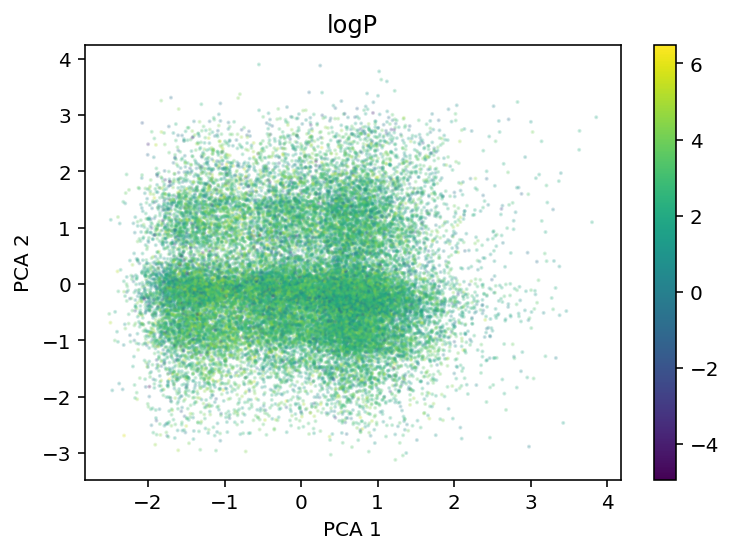

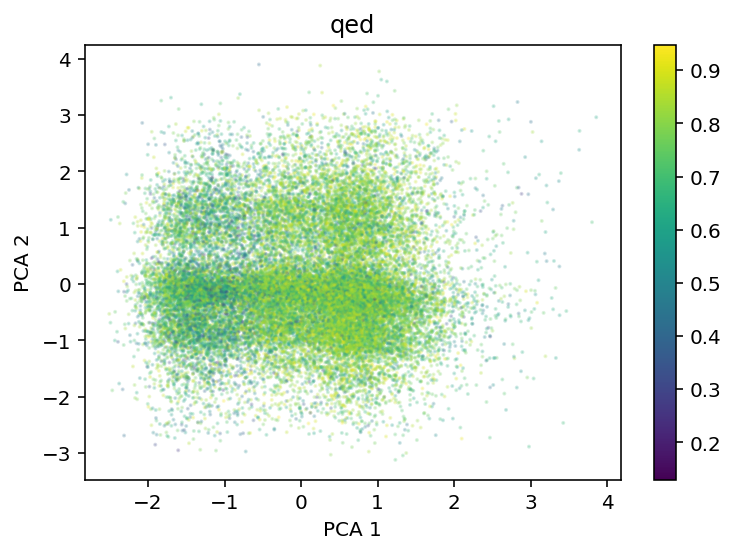

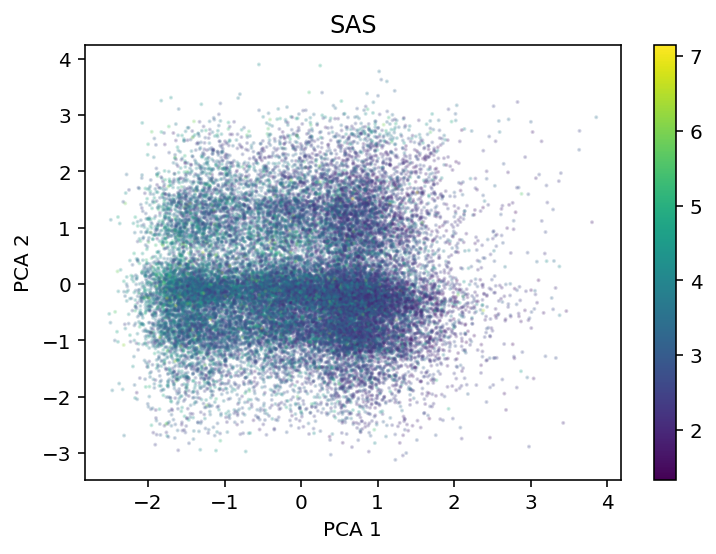

In [170]:
plot_pca(loader, model, size=30_000)